In [1]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocessor
# from albumentations import (
#     HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
#     Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
#     IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
#     IAASharpen, IAAEmboss, Flip, OneOf, Compose
# )


plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Step1 Prepare Dataset
##### **In our dataset we have 3 parts**:


1.   Partition 0 for training 162770
2.   Partition 1 for testing 19962
3.   Partition 2 for validation 19867

**we will use partition 1 as training set and 1 for testing and 2 for validation**



In [ ]:
# Some predefined variables & hyper parameters
main_folder = "./"
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'
EXAMPLE_PIC = images_folder + '202599.jpg'
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 128
NUM_EPOCHS = 50

In [ ]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
# Recomended partition
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr, how='inner')
df_par_attr.reset_index(inplace=True)

In [ ]:
df_par_attr.head(5)

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
# Creating generator 
def generator(samples, batch_size=BATCH_SIZE, 
              shuffle_data=True,IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT,
              model_preprocessor=None):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = df_par_attr.sample(frac = 1)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples.iloc[offset:offset+batch_size, :]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for i in batch_samples.index:
                # Load image (X) and label (y)
                # print("now inedex : ", i)
                img_name = batch_samples["image_id"][i]
                label = list(np.array(batch_samples[batch_samples.index==i].iloc[:, 2:])[0])
                
                img =  cv2.imread('img_align_celeba/img_align_celeba/'+img_name)
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
                # Add example to arrays
                if model_preprocessor:
                  img = model_preprocessor(img)
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

## Generate Partitions (Train, Validation, Test)

In [ ]:
training_data = df_par_attr[df_par_attr["partition"]==0]
validation_data = df_par_attr[df_par_attr["partition"]==2]
testing_data = df_par_attr[df_par_attr["partition"]==1]

In [ ]:
len(testing_data)

19867

In [ ]:
traing_g = generator(training_data, model_preprocessor=inception_preprocess)
validation_g = generator(validation_data, model_preprocessor=inception_preprocess)
testing_g = generator(testing_data, model_preprocessor=inception_preprocess)

In [ ]:
def get_results(testing_data, testing_g, BATCH_SIZE):
  prediction = []
  real = []
  for i in range(len(testing_data)//BATCH_SIZE):
    images, labels = next(testing_g)
    # for img, lab in zip(images, labels):
    for pred, true in zip(model_.predict(images), labels):
      prediction.append(pred)
      real.append(true)
  ##############################
  prediction = pd.DataFrame(prediction)
  prediction.columns = list(df_par_attr.head().columns)[2:]
  real = pd.DataFrame(real)
  real.columns = list(df_par_attr.head().columns)[2:]

  for col in prediction.columns:
    for index in range(len(prediction)):
        if prediction[col][index] >= 0.5:
          prediction[col][index] = int(1)
        else:
          prediction[col][index] = int(0)
  prediction = prediction.astype(int)

  accuracies = {}
  for col in prediction.columns:
    y_true = list(real[col])
    y_pred = list(prediction[col])
    acc = accuracy_score(y_true, y_pred)
    accuracies[col] = acc
    print("accuracy of "+col+" is : "+str(acc))
  print("**** OVERALL ACCURACY: ", sum(list(accuracies.values()))/len(list(accuracies.values())))  

# Inception v3 Model and Adding custom layers

<h2>Inception-V3 model structure</h2>
This is the structure of the Inception-V3 model, developed over the imagenet dataset.


<img src="https://i.imgur.com/kdXUzu1.png" width="1000px"/>
source: https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png

The top layers (including classification) are not included. These layers will be replaced for the following layers:

In [ ]:
!wget https://raw.githubusercontent.com/kohpangwei/influence-release/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

--2020-04-28 17:37:11--  https://raw.githubusercontent.com/kohpangwei/influence-release/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/octet-stream]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   187MB/s    in 0.4s    

2020-04-28 17:37:12 (187 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


number of layers: 311


In [ ]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(40, activation="sigmoid")(x)

<h2>New Top layers</h2>
Layers to be trained with the new model.
<img src="https://i.imgur.com/rWF7bRY.png" width="800px"/>

In [ ]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:300]:
    layer.trainable = False

#### Using SGD optimizer

In [ ]:
# compile the model
model_.compile(optimizer=SGD(lr=0.001, momentum=0.9)
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
hist = model_.fit_generator(traing_g,
                     validation_data = validation_g
                      , steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10
                      ,validation_steps = validation_data.shape[0] // BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )


Epoch 1/50
127/127 [==============================] - 119s 940ms/step - loss: 0.5939 - accuracy: 0.6914 - val_loss: 0.4517 - val_accuracy: 0.7993

Epoch 00001: val_loss improved from inf to 0.45166, saving model to weights.best.inc.hdf5
Epoch 2/50
127/127 [==============================] - 108s 851ms/step - loss: 0.4590 - accuracy: 0.8006 - val_loss: 0.4495 - val_accuracy: 0.8065

Epoch 00002: val_loss improved from 0.45166 to 0.44949, saving model to weights.best.inc.hdf5
Epoch 3/50
127/127 [==============================] - 110s 864ms/step - loss: 0.4425 - accuracy: 0.8037 - val_loss: 0.4432 - val_accuracy: 0.8080

Epoch 00003: val_loss improved from 0.44949 to 0.44322, saving model to weights.best.inc.hdf5
Epoch 4/50
127/127 [==============================] - 110s 867ms/step - loss: 0.4395 - accuracy: 0.8050 - val_loss: 0.4370 - val_accuracy: 0.8107

Epoch 00004: val_loss improved from 0.44322 to 0.43697, saving model to weights.best.inc.hdf5
Epoch 5/50
127/127 [===================

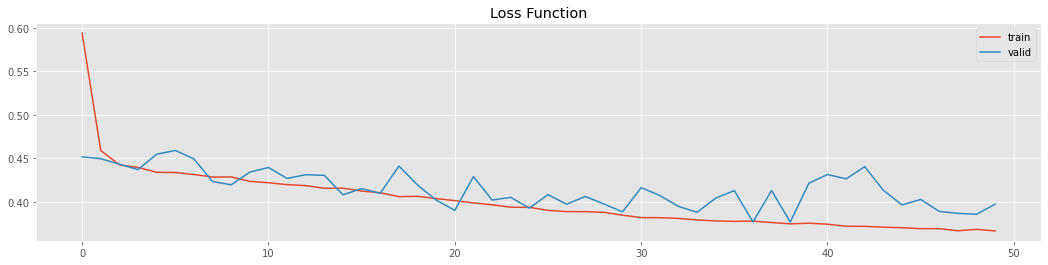

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

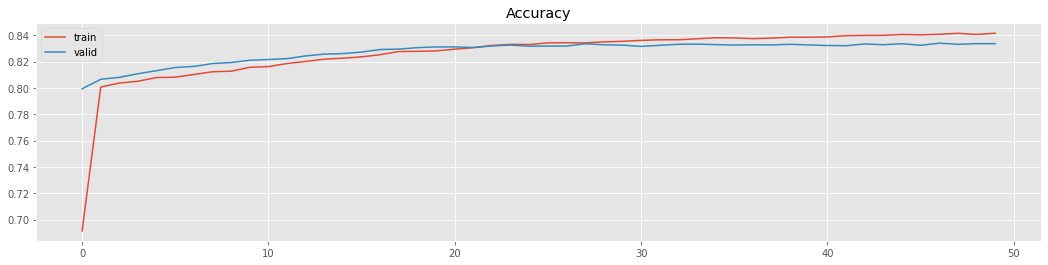

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
get_results(testing_data, testing_g, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.8897177419354839
accuracy of Arched_Eyebrows is : 0.7172883064516129
accuracy of Attractive is : 0.6773689516129032
accuracy of Bags_Under_Eyes is : 0.7954637096774193
accuracy of Bald is : 0.9765625
accuracy of Bangs is : 0.8436995967741936
accuracy of Big_Lips is : 0.756149193548387
accuracy of Big_Nose is : 0.7666834677419355
accuracy of Black_Hair is : 0.7575604838709677
accuracy of Blond_Hair is : 0.8561995967741935
accuracy of Blurry is : 0.9478326612903226
accuracy of Brown_Hair is : 0.7965725806451613
accuracy of Bushy_Eyebrows is : 0.8592741935483871
accuracy of Chubby is : 0.9427923387096774
accuracy of Double_Chin is : 0.953125
accuracy of Eyeglasses is : 0.9338709677419355
accuracy of Goatee is : 0.9369959677419355
accuracy of Gray_Hair is : 0.9552419354838709
accuracy of Heavy_Makeup is : 0.7982358870967742
accuracy of High_Cheekbones is : 0.5950100806451613
accuracy of Male is : 0.8566532258064516
accuracy of Mouth_Slightly_Open is : 0.

## Now Change the optimizer to adam

In [ ]:
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(40, activation="sigmoid")(x)


# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:300]:
    layer.trainable = False




# compile the model
model_.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.hdf5', 
                               verbose=1, save_best_only=True)


hist = model_.fit_generator(traing_g,
                     validation_data = validation_g
                      , steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10
                      ,validation_steps = validation_data.shape[0] // BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/50
127/127 [==============================] - 117s 925ms/step - loss: 0.3682 - accuracy: 0.8378 - val_loss: 0.4641 - val_accuracy: 0.8171

Epoch 00001: val_loss improved from inf to 0.46407, saving model to weights.best.inc.hdf5
Epoch 2/50
127/127 [==============================] - 109s 855ms/step - loss: 0.3280 - accuracy: 0.8556 - val_loss: 0.4086 - val_accuracy: 0.8349

Epoch 00002: val_loss improved from 0.46407 to 0.40856, saving model to weights.best.inc.hdf5
Epoch 3/50
127/127 [==============================] - 111s 873ms/step - loss: 0.3188 - accuracy: 0.8598 - val_loss: 0.4373 - val_accuracy: 0.8309

Epoch 00003: val_loss did not improve from 0.40856
Epoch 4/50
127/127 [==============================] - 111s 872ms/step - loss: 0.3155 - accuracy: 0.8615 - val_loss: 0.4806 - val_accuracy: 0.8252

Epoch 00004: val_loss did not improve from 0.40856
Epoch 5/50
127/127 [==============================] - 110s 865ms/step - loss: 0.3131 - accuracy: 0.8626 - val_loss: 0.4346 - v

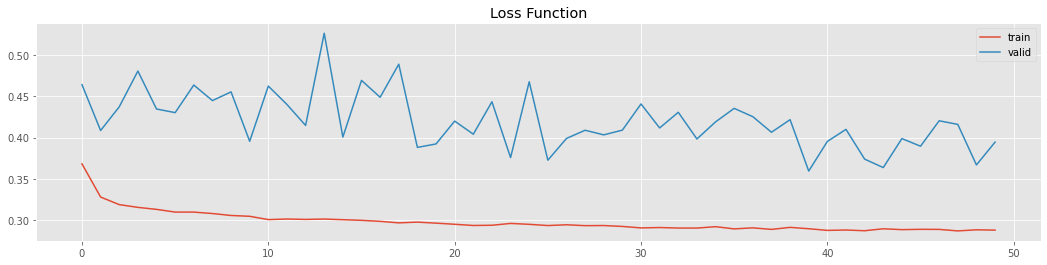

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

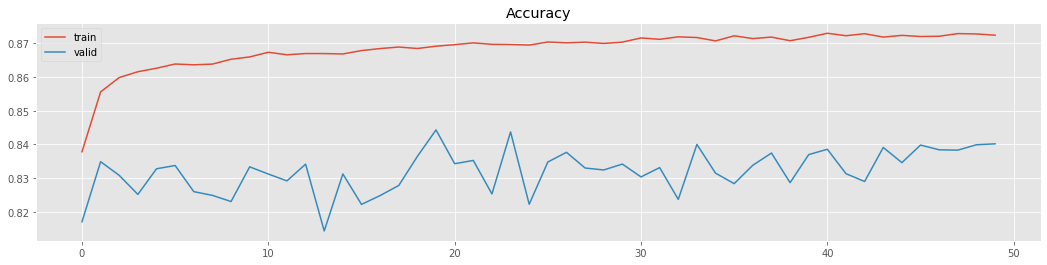

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
get_results(testing_data, testing_g, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.884475806451613
accuracy of Arched_Eyebrows is : 0.756804435483871
accuracy of Attractive is : 0.6400201612903226
accuracy of Bags_Under_Eyes is : 0.7924899193548387
accuracy of Bald is : 0.9787802419354839
accuracy of Bangs is : 0.885383064516129
accuracy of Big_Lips is : 0.7539314516129032
accuracy of Big_Nose is : 0.7704637096774194
accuracy of Black_Hair is : 0.7610383064516129
accuracy of Blond_Hair is : 0.8990927419354838
accuracy of Blurry is : 0.9492943548387097
accuracy of Brown_Hair is : 0.7310483870967742
accuracy of Bushy_Eyebrows is : 0.8537298387096774
accuracy of Chubby is : 0.941179435483871
accuracy of Double_Chin is : 0.9519153225806452
accuracy of Eyeglasses is : 0.9527721774193548
accuracy of Goatee is : 0.9382560483870968
accuracy of Gray_Hair is : 0.9578125
accuracy of Heavy_Makeup is : 0.7850302419354839
accuracy of High_Cheekbones is : 0.6694052419354839
accuracy of Male is : 0.8702620967741935
accuracy of Mouth_Slightly_Open 

## Now freeze only first 150 layers of inception model

In [ ]:
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(40, activation="sigmoid")(x)


# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:150]:
    layer.trainable = False




# compile the model
model_.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
NUM_EPOCHS =10
checkpointer = ModelCheckpoint(filepath='weights.best.inc.hdf5', 
                               verbose=1, save_best_only=True)


hist = model_.fit_generator(traing_g,
                     validation_data = validation_g
                      , steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10
                      ,validation_steps = validation_data.shape[0] // BATCH_SIZE//10
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/10
127/127 [==============================] - 52s 409ms/step - loss: 0.2117 - accuracy: 0.9079 - val_loss: 0.2587 - val_accuracy: 0.8880

Epoch 00001: val_loss improved from inf to 0.25866, saving model to weights.best.inc.hdf5
Epoch 2/10
127/127 [==============================] - 50s 391ms/step - loss: 0.2116 - accuracy: 0.9078 - val_loss: 0.2877 - val_accuracy: 0.8833

Epoch 00002: val_loss did not improve from 0.25866
Epoch 3/10
127/127 [==============================] - 50s 394ms/step - loss: 0.2124 - accuracy: 0.9077 - val_loss: 0.2802 - val_accuracy: 0.8870

Epoch 00003: val_loss did not improve from 0.25866
Epoch 4/10
127/127 [==============================] - 50s 392ms/step - loss: 0.2109 - accuracy: 0.9081 - val_loss: 0.2546 - val_accuracy: 0.8920

Epoch 00004: val_loss improved from 0.25866 to 0.25457, saving model to weights.best.inc.hdf5
Epoch 5/10
127/127 [==============================] - 49s 389ms/step - loss: 0.2109 - accuracy: 0.9082 - val_loss: 0.2601 - val_ac

In [ ]:
model_.load_weights('weights.best.inc.hdf5')

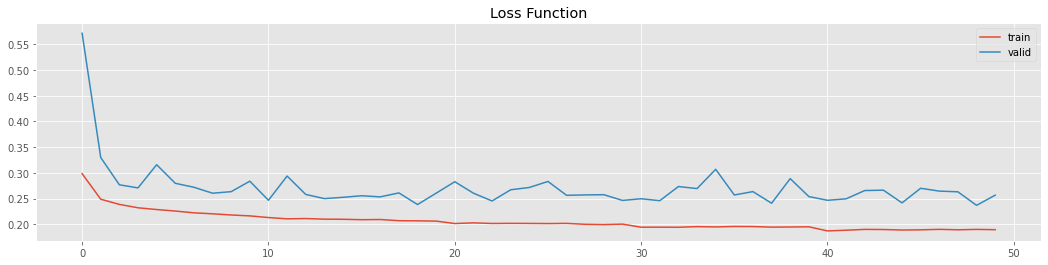

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

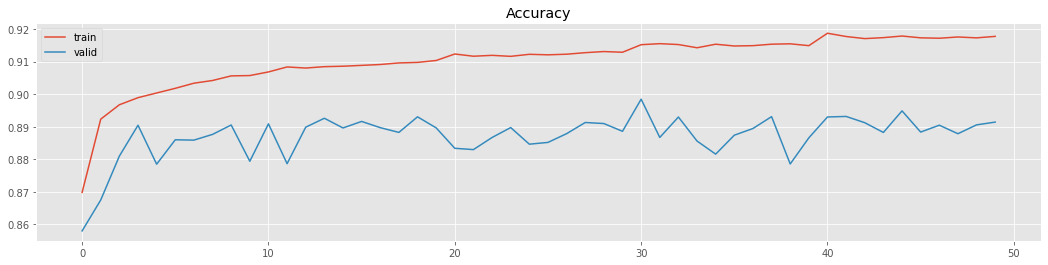

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
get_results(testing_data, testing_g, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.9225302419354838
accuracy of Arched_Eyebrows is : 0.7979334677419355
accuracy of Attractive is : 0.7868447580645161
accuracy of Bags_Under_Eyes is : 0.8078125
accuracy of Bald is : 0.989616935483871
accuracy of Bangs is : 0.9530241935483871
accuracy of Big_Lips is : 0.7736895161290323
accuracy of Big_Nose is : 0.8067540322580645
accuracy of Black_Hair is : 0.8237399193548387
accuracy of Blond_Hair is : 0.9498991935483871
accuracy of Blurry is : 0.956703629032258
accuracy of Brown_Hair is : 0.7521169354838709
accuracy of Bushy_Eyebrows is : 0.9145665322580645
accuracy of Chubby is : 0.958266129032258
accuracy of Double_Chin is : 0.9620463709677419
accuracy of Eyeglasses is : 0.9916834677419355
accuracy of Goatee is : 0.9686491935483871
accuracy of Gray_Hair is : 0.9680947580645162
accuracy of Heavy_Makeup is : 0.8790826612903225
accuracy of High_Cheekbones is : 0.8608870967741935
accuracy of Male is : 0.9532762096774193
accuracy of Mouth_Slightly_Open

# RESNET50

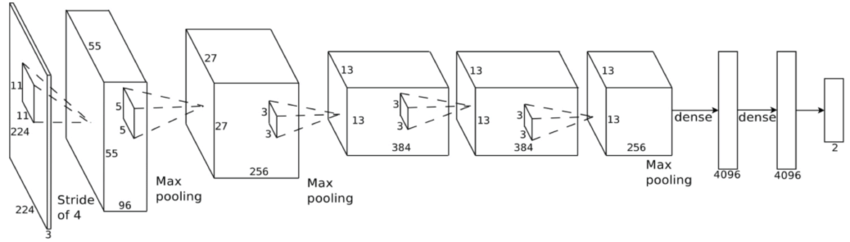

## RESNET with SGD

In [ ]:
traing_g = generator(training_data, model_preprocessor=resnet_preprocessor)
validation_g = generator(validation_data, model_preprocessor=resnet_preprocessor)
testing_g = generator(testing_data, model_preprocessor=resnet_preprocessor)

In [ ]:
#
model = ResNet50(weights='imagenet')

print("number of layers:", len(model.layers))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

102858752/102853048 [==============================] - 10s 0us/step
number of layers: 177


In [ ]:
#Adding custom Layers
x = model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(40, activation="sigmoid")(x)

In [ ]:
# creating the final model 
model_ = Model(inputs=model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:100]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.001, momentum=0.9)
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
hist = model_.fit_generator(traing_g,
                     validation_data = validation_g
                      , steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10
                      ,validation_steps = validation_data.shape[0] // BATCH_SIZE //10
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )


Epoch 1/50
127/127 [==============================] - 211s 2s/step - loss: 0.6905 - accuracy: 0.7164 - val_loss: 0.6873 - val_accuracy: 0.7875

Epoch 00001: val_loss improved from inf to 0.68728, saving model to weights.best.hdf5
Epoch 2/50
127/127 [==============================] - 194s 2s/step - loss: 0.6842 - accuracy: 0.7962 - val_loss: 0.6805 - val_accuracy: 0.8003

Epoch 00002: val_loss improved from 0.68728 to 0.68048, saving model to weights.best.hdf5
Epoch 3/50
127/127 [==============================] - 194s 2s/step - loss: 0.6772 - accuracy: 0.8008 - val_loss: 0.6732 - val_accuracy: 0.7995

Epoch 00003: val_loss improved from 0.68048 to 0.67322, saving model to weights.best.hdf5
Epoch 4/50
127/127 [==============================] - 194s 2s/step - loss: 0.6699 - accuracy: 0.7997 - val_loss: 0.6658 - val_accuracy: 0.8019

Epoch 00004: val_loss improved from 0.67322 to 0.66578, saving model to weights.best.hdf5
Epoch 5/50
127/127 [==============================] - 194s 2s/step 

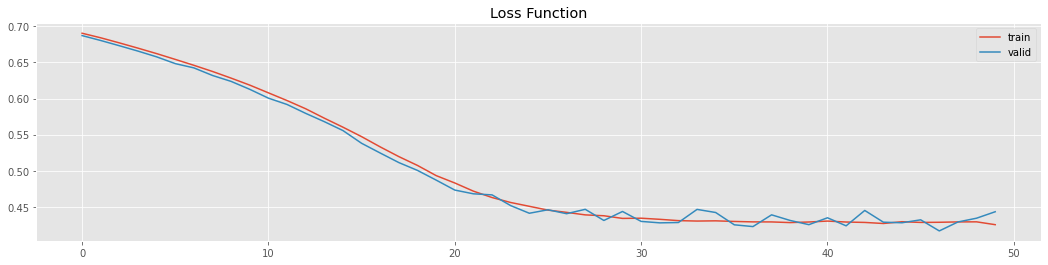

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

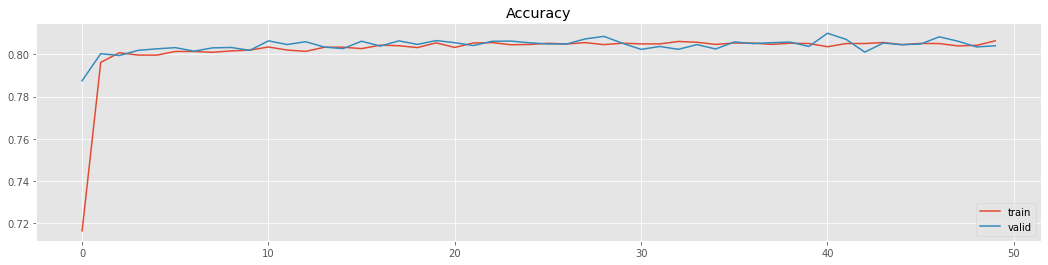

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
get_results(testing_data, testing_g, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.8897681451612903
accuracy of Arched_Eyebrows is : 0.7336189516129032
accuracy of Attractive is : 0.5091229838709678
accuracy of Bags_Under_Eyes is : 0.7950100806451613
accuracy of Bald is : 0.9764112903225807
accuracy of Bangs is : 0.8502520161290322
accuracy of Big_Lips is : 0.7611895161290323
accuracy of Big_Nose is : 0.7652217741935484
accuracy of Black_Hair is : 0.7578629032258064
accuracy of Blond_Hair is : 0.8549899193548387
accuracy of Blurry is : 0.948991935483871
accuracy of Brown_Hair is : 0.7962701612903226
accuracy of Bushy_Eyebrows is : 0.8581149193548387
accuracy of Chubby is : 0.9415826612903225
accuracy of Double_Chin is : 0.9516129032258065
accuracy of Eyeglasses is : 0.9379536290322581
accuracy of Goatee is : 0.9371471774193548
accuracy of Gray_Hair is : 0.9587197580645161
accuracy of Heavy_Makeup is : 0.6134072580645161
accuracy of High_Cheekbones is : 0.5404233870967742
accuracy of Male is : 0.5847278225806452
accuracy of Mouth_Sl

## USE ADAM optimizer 

In [ ]:
#
model = ResNet50(weights='imagenet')

print("number of layers:", len(model.layers))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

102858752/102853048 [==============================] - 9s 0us/step
number of layers: 177


In [ ]:
#Adding custom Layers
x = model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(40, activation="sigmoid")(x)


# creating the final model 
model_ = Model(inputs=model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:100]:
    layer.trainable = False




# compile the model
model_.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)

hist = model_.fit_generator(traing_g,
                     validation_data = validation_g
                      , steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10
                      ,validation_steps = validation_data.shape[0] // BATCH_SIZE //10
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/50
127/127 [==============================] - 220s 2s/step - loss: 0.3791 - accuracy: 0.8306 - val_loss: 0.5918 - val_accuracy: 0.7782

Epoch 00001: val_loss improved from inf to 0.59177, saving model to weights.best.hdf5
Epoch 2/50
127/127 [==============================] - 208s 2s/step - loss: 0.3276 - accuracy: 0.8569 - val_loss: 0.8456 - val_accuracy: 0.7577

Epoch 00002: val_loss did not improve from 0.59177
Epoch 3/50
127/127 [==============================] - 208s 2s/step - loss: 0.3013 - accuracy: 0.8697 - val_loss: 0.6274 - val_accuracy: 0.7863

Epoch 00003: val_loss did not improve from 0.59177
Epoch 4/50
127/127 [==============================] - 208s 2s/step - loss: 0.2895 - accuracy: 0.8752 - val_loss: 0.7583 - val_accuracy: 0.7898

Epoch 00004: val_loss did not improve from 0.59177
Epoch 5/50
127/127 [==============================] - 208s 2s/step - loss: 0.2816 - accuracy: 0.8778 - val_loss: 0.6966 - val_accuracy: 0.7711

Epoch 00005: val_loss did not improve fro

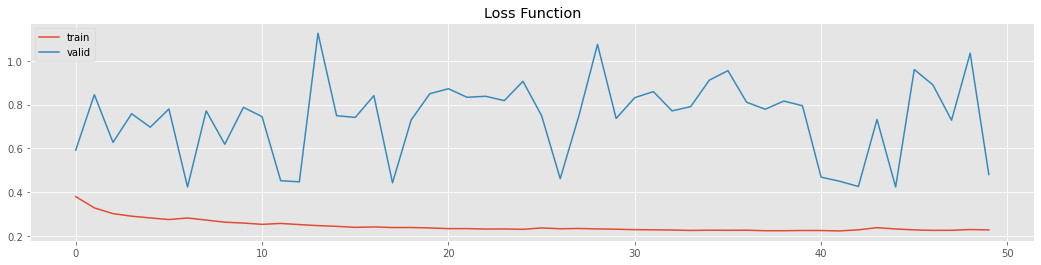

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

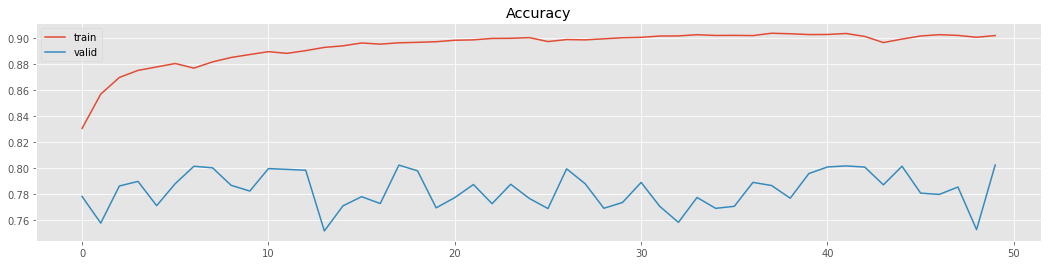

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
get_results(testing_data, testing_g, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.8830141129032258
accuracy of Arched_Eyebrows is : 0.7356350806451613
accuracy of Attractive is : 0.4832661290322581
accuracy of Bags_Under_Eyes is : 0.7959677419354839
accuracy of Bald is : 0.9790826612903226
accuracy of Bangs is : 0.8475302419354839
accuracy of Big_Lips is : 0.7618447580645161
accuracy of Big_Nose is : 0.7651209677419355
accuracy of Black_Hair is : 0.7552923387096774
accuracy of Blond_Hair is : 0.8503528225806452
accuracy of Blurry is : 0.9508064516129032
accuracy of Brown_Hair is : 0.7934979838709677
accuracy of Bushy_Eyebrows is : 0.8580141129032258
accuracy of Chubby is : 0.9477318548387097
accuracy of Double_Chin is : 0.9555947580645161
accuracy of Eyeglasses is : 0.9383568548387097
accuracy of Goatee is : 0.9377520161290323
accuracy of Gray_Hair is : 0.9577620967741935
accuracy of Heavy_Makeup is : 0.613508064516129
accuracy of High_Cheekbones is : 0.5431451612903225
accuracy of Male is : 0.4564012096774194
accuracy of Mouth_Sl

## RESNET with SGD with 40 layers freezed

In [ ]:
#
model = ResNet50(weights='imagenet')

print("number of layers:", len(model.layers))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

102858752/102853048 [==============================] - 3s 0us/step
number of layers: 177


In [ ]:
#Adding custom Layers
x = model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(40, activation="sigmoid")(x)


# creating the final model 
model_ = Model(inputs=model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:40]:
    layer.trainable = False




# compile the model
model_.compile(optimizer=SGD(lr=0.001, momentum=0.9)
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)

hist = model_.fit_generator(traing_g,
                     validation_data = validation_g
                      , steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10
                      ,validation_steps = validation_data.shape[0] // BATCH_SIZE //10
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )


Epoch 1/50
127/127 [==============================] - 89s 698ms/step - loss: 0.6907 - accuracy: 0.7063 - val_loss: 0.6875 - val_accuracy: 0.7918

Epoch 00001: val_loss improved from inf to 0.68751, saving model to weights.best.hdf5
Epoch 2/50
127/127 [==============================] - 72s 566ms/step - loss: 0.6841 - accuracy: 0.7980 - val_loss: 0.6804 - val_accuracy: 0.8015

Epoch 00002: val_loss improved from 0.68751 to 0.68043, saving model to weights.best.hdf5
Epoch 3/50
127/127 [==============================] - 72s 567ms/step - loss: 0.6769 - accuracy: 0.8020 - val_loss: 0.6731 - val_accuracy: 0.8039

Epoch 00003: val_loss improved from 0.68043 to 0.67312, saving model to weights.best.hdf5
Epoch 4/50
127/127 [==============================] - 72s 566ms/step - loss: 0.6695 - accuracy: 0.8025 - val_loss: 0.6654 - val_accuracy: 0.8051

Epoch 00004: val_loss improved from 0.67312 to 0.66540, saving model to weights.best.hdf5
Epoch 5/50
127/127 [==============================] - 72s 5

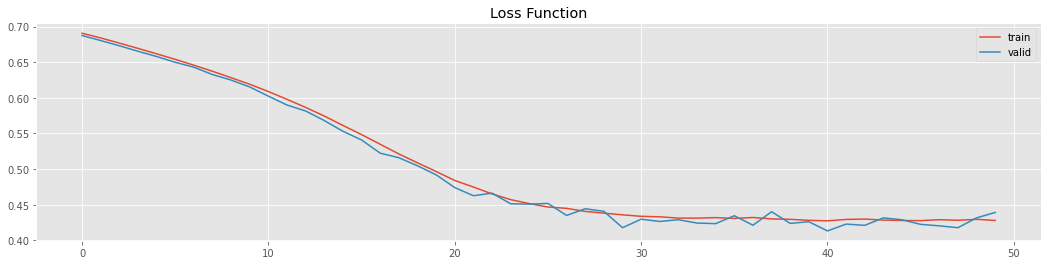

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

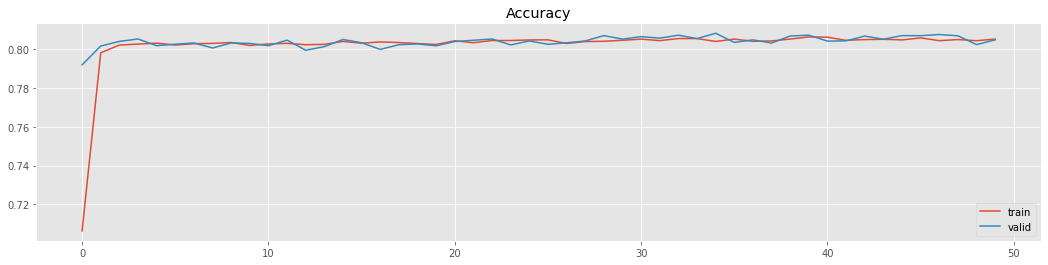

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
get_results(testing_data, testing_g, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.889616935483871
accuracy of Arched_Eyebrows is : 0.7365423387096774
accuracy of Attractive is : 0.5159274193548387
accuracy of Bags_Under_Eyes is : 0.7972278225806452
accuracy of Bald is : 0.9754536290322581
accuracy of Bangs is : 0.8473790322580645
accuracy of Big_Lips is : 0.7634072580645161
accuracy of Big_Nose is : 0.7626008064516129
accuracy of Black_Hair is : 0.7644153225806452
accuracy of Blond_Hair is : 0.8518649193548387
accuracy of Blurry is : 0.9466733870967742
accuracy of Brown_Hair is : 0.7957661290322581
accuracy of Bushy_Eyebrows is : 0.8594758064516129
accuracy of Chubby is : 0.9423387096774194
accuracy of Double_Chin is : 0.9497983870967742
accuracy of Eyeglasses is : 0.9360887096774193
accuracy of Goatee is : 0.9392137096774194
accuracy of Gray_Hair is : 0.9558971774193549
accuracy of Heavy_Makeup is : 0.609929435483871
accuracy of High_Cheekbones is : 0.5444556451612903
accuracy of Male is : 0.5819556451612903
accuracy of Mouth_Sli

# Play with the model

In [ ]:
images, labels = next(testing_g)

In [ ]:
 start = "\033[1m"
 end = "\033[0;0m"

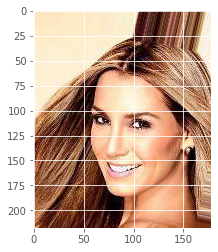

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

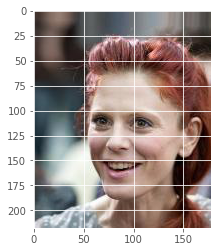

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 1
Bags_Under_Eyes True: 1 Predicted: 1
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

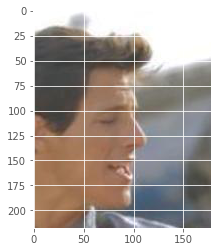

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 1 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

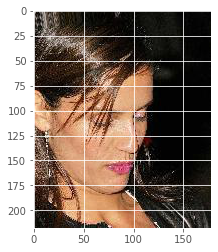

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

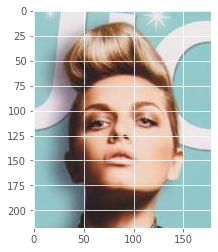

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

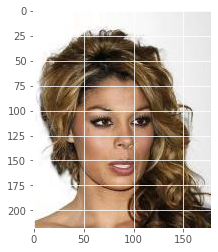

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

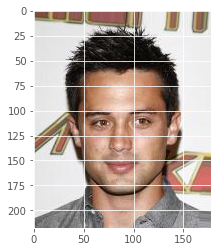

5_o_Clock_Shadow True: 1 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 1 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 1 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

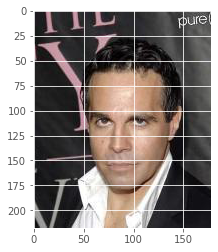

5_o_Clock_Shadow True: 1 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 0 Predicted: 1
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 1 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

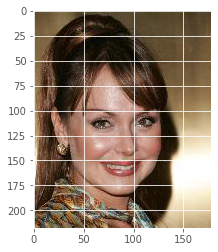

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 1 Predicted: 1
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 1 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 1 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

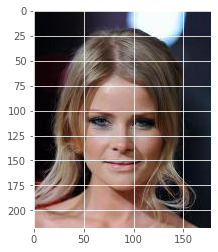

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

In [ ]:
# img_index=1
for img_index in range(10):
  org_img = load_img(images_folder + df_par_attr["image_id"][img_index])
  real = []
  for col in df_par_attr.columns[2:]:
    real.append(df_par_attr[col][img_index])
  img = img_to_array(org_img)
  img = inception_preprocess(cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT)))
  predictions = model_.predict(np.array([img]))
  predictions = list(predictions[0])
  plt.imshow(org_img)
  plt.show()

  for true, pred , col in zip(real, predictions, df_par_attr.columns[2:]):
    pred = 1 if pred >=0.5 else 0
    if pred==true:
      print("\033[1;32m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)
    else:
      print("\033[1;31m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)


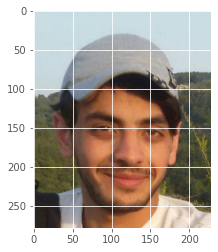

5_o_Clock_ShadowPredicted: 0
Arched_EyebrowsPredicted: 0
AttractivePredicted: 1
Bags_Under_EyesPredicted: 0
BaldPredicted: 0
BangsPredicted: 0
Big_LipsPredicted: 0
Big_NosePredicted: 0
Black_HairPredicted: 0
Blond_HairPredicted: 0
BlurryPredicted: 0
Brown_HairPredicted: 0
Bushy_EyebrowsPredicted: 1
ChubbyPredicted: 0
Double_ChinPredicted: 0
EyeglassesPredicted: 0
GoateePredicted: 0
Gray_HairPredicted: 0
Heavy_MakeupPredicted: 0
High_CheekbonesPredicted: 0
MalePredicted: 1
Mouth_Slightly_OpenPredicted: 0
MustachePredicted: 0
Narrow_EyesPredicted: 0
No_BeardPredicted: 1
Oval_FacePredicted: 0
Pale_SkinPredicted: 1
Pointy_NosePredicted: 0
Receding_HairlinePredicted: 0
Rosy_CheeksPredicted: 0
SideburnsPredicted: 0
SmilingPredicted: 0
Straight_HairPredicted: 0
Wavy_HairPredicted: 0
Wearing_EarringsPredicted: 0
Wearing_HatPredicted: 0
Wearing_LipstickPredicted: 0
Wearing_NecklacePredicted: 0
Wearing_NecktiePredicted: 0
YoungPredicted: 1


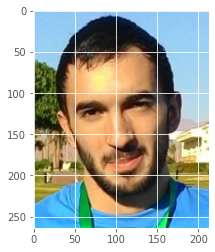

5_o_Clock_ShadowPredicted: 1
Arched_EyebrowsPredicted: 0
AttractivePredicted: 1
Bags_Under_EyesPredicted: 0
BaldPredicted: 0
BangsPredicted: 0
Big_LipsPredicted: 0
Big_NosePredicted: 0
Black_HairPredicted: 0
Blond_HairPredicted: 0
BlurryPredicted: 0
Brown_HairPredicted: 0
Bushy_EyebrowsPredicted: 1
ChubbyPredicted: 0
Double_ChinPredicted: 0
EyeglassesPredicted: 0
GoateePredicted: 1
Gray_HairPredicted: 0
Heavy_MakeupPredicted: 0
High_CheekbonesPredicted: 0
MalePredicted: 1
Mouth_Slightly_OpenPredicted: 0
MustachePredicted: 0
Narrow_EyesPredicted: 0
No_BeardPredicted: 0
Oval_FacePredicted: 0
Pale_SkinPredicted: 0
Pointy_NosePredicted: 0
Receding_HairlinePredicted: 0
Rosy_CheeksPredicted: 0
SideburnsPredicted: 0
SmilingPredicted: 0
Straight_HairPredicted: 0
Wavy_HairPredicted: 0
Wearing_EarringsPredicted: 0
Wearing_HatPredicted: 0
Wearing_LipstickPredicted: 0
Wearing_NecklacePredicted: 0
Wearing_NecktiePredicted: 0
YoungPredicted: 1


In [ ]:
test_img = ["teting2.png", "testing.png"]
for img_path in test_img:
  org_img = load_img(img_path)
  img = img_to_array(org_img)
  img = inception_preprocess(cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT)))
  predictions = model_.predict(np.array([img]))
  predictions = list(predictions[0])
  plt.imshow(org_img)
  plt.show()

  for pred , col in zip( predictions, df_par_attr.columns[2:]):
    pred = 1 if pred >=0.5 else 0
    
    print("\033[1;32m"+start+col+ "Predicted: "+str(pred)+end)

